In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import timm

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from pyts.image import GramianAngularField, MarkovTransitionField
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# Create a toy time series using the sine function
time_points = np.linspace(0, 4 * np.pi, 1000)
x = np.sin(time_points)
X = np.array([x])

# Compute Gramian angular fields
mtf = MarkovTransitionField(n_bins=8)
X_mtf = mtf.fit_transform(X)


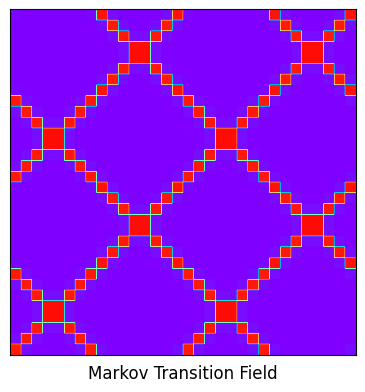

In [7]:

# Plot the time series and its Markov transition field
width_ratios = (2, 7, 0.4)
height_ratios = (2, 7)
width = 6
height = width * sum(height_ratios) / sum(width_ratios)
fig = plt.figure(figsize=(width, height))
gs = fig.add_gridspec(2, 3,  width_ratios=width_ratios,
                      height_ratios=height_ratios,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# # Define the ticks and their labels for both axes
# time_ticks = np.linspace(0, 4 * np.pi, 9)
# time_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$',
#                    r'$\frac{3\pi}{2}$', r'$2\pi$', r'$\frac{5\pi}{2}$',
#                    r'$3\pi$', r'$\frac{7\pi}{2}$', r'$4\pi$']
# value_ticks = [-1, 0, 1]
# reversed_value_ticks = value_ticks[::-1]

# # Plot the time series on the left with inverted axes
# ax_left = fig.add_subplot(gs[1, 0])
# ax_left.plot(x, time_points)
# ax_left.set_xticks(reversed_value_ticks)
# ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
# ax_left.set_yticks(time_ticks)
# ax_left.set_yticklabels(time_ticklabels, rotation=90)
# ax_left.set_ylim((0, 4 * np.pi))
# ax_left.invert_xaxis()

# # Plot the time series on the top
# ax_top = fig.add_subplot(gs[0, 1])
# ax_top.plot(time_points, x)
# ax_top.set_xticks(time_ticks)
# ax_top.set_xticklabels(time_ticklabels)
# ax_top.set_yticks(value_ticks)
# ax_top.set_yticklabels(value_ticks)
# ax_top.xaxis.tick_top()
# ax_top.set_xlim((0, 4 * np.pi))
# ax_top.set_yticklabels(value_ticks)

# Plot the Gramian angular fields on the bottom right
ax_mtf = fig.add_subplot(gs[1, 1])
im = ax_mtf.imshow(X_mtf[0], cmap='rainbow', origin='lower', vmin=0., vmax=1.,
                   extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_mtf.set_xticks([])
ax_mtf.set_yticks([])
ax_mtf.set_title('Markov Transition Field', y=-0.09)

# # Add colorbar
# ax_cbar = fig.add_subplot(gs[1, 2])
# fig.colorbar(im, cax=ax_cbar)

plt.show()

## Markov Transition Field

In [ ]:
mtf0 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf1 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf2 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf3 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf4 = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)

In [ ]:
mtf_train_f0 = mtf0.fit_transform(data_train_transposed[:, 0, :])
mtf_train_f1 = mtf1.fit_transform(data_train_transposed[:, 1, :])
mtf_train_f2 = mtf2.fit_transform(data_train_transposed[:, 2, :])
mtf_train_f3 = mtf3.fit_transform(data_train_transposed[:, 3, :])
mtf_train_f4 = mtf4.fit_transform(data_train_transposed[:, 4, :])

In [ ]:
mtf_train = np.empty((data_train_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_train[i][j][k] = (mtf_train_f0[i][j][k] + mtf_train_f1[i][j][k] + mtf_train_f2[i][j][k] + mtf_train_f3[i][j][k] + mtf_train_f4[i][j][k])/5

In [ ]:
mtf_img_train_tmp = []

for g in mtf_train:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_train_tmp.append(image_array)

In [ ]:
mtf_img_train = np.stack(mtf_img_train_tmp, axis=0)
mtf_img_train = mtf_img_train/255
mtf_img_train.shape

(208, 64, 64, 4)

In [ ]:
mtf_test_f0 = mtf0.transform(data_test_transposed[:, 0, :])
mtf_test_f1 = mtf1.transform(data_test_transposed[:, 1, :])
mtf_test_f2 = mtf2.transform(data_test_transposed[:, 2, :])
mtf_test_f3 = mtf3.transform(data_test_transposed[:, 3, :])
mtf_test_f4 = mtf4.transform(data_test_transposed[:, 4, :])

In [ ]:
mtf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_test[i][j][k] = (mtf_test_f0[i][j][k] + mtf_test_f1[i][j][k] + mtf_test_f2[i][j][k] + mtf_test_f3[i][j][k] + mtf_test_f4[i][j][k])/5

In [ ]:
mtf_img_test_tmp = []

for g in mtf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_test_tmp.append(image_array)

In [ ]:
mtf_img_test = np.stack(mtf_img_test_tmp, axis=0)
mtf_img_test = mtf_img_test/255
mtf_img_test.shape

(53, 64, 64, 4)

### CNN

In [ ]:
tf.random.set_seed(SEED)
cnn_mtf = Sequential(name='CNN_MTF')
cnn_mtf.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mtf_img_train.shape[1], mtf_img_train.shape[2], mtf_img_train.shape[3])))
cnn_mtf.add(MaxPooling2D((2, 2)))
cnn_mtf.add(Dropout(0.2))
cnn_mtf.add (Conv2D(16, (3, 3), activation='relu'))
cnn_mtf.add(MaxPooling2D((2, 2)))
cnn_mtf.add(Dropout(0.2))
cnn_mtf.add (Conv2D(8, (3, 3), activation='relu'))
cnn_mtf.add(Flatten())
cnn_mtf.add(Dense(8, activation='relu'))
cnn_mtf.add(Dense(NUMCLASS, activation='softmax'))

cnn_mtf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_mtf.summary()

Model: "CNN_MTF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         9,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,210 (63.32 KB)

 Trainable params: 16,210 (63.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.random.set_seed(SEED)
cnn_mtf_history = cnn_mtf.fit(mtf_img_train, to_categorical(y_train_int), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6026 - loss: 0.6764 - val_accuracy: 0.7857 - val_loss: 0.5804
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7888 - loss: 0.5127 - val_accuracy: 0.7857 - val_loss: 0.5492
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7888 - loss: 0.6132 - val_accuracy: 0.7857 - val_loss: 0.5219
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7888 - loss: 0.5222 - val_accuracy: 0.7857 - val_loss: 0.5347
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7888 - loss: 0.5163 - val_accuracy: 0.7857 - val_loss: 0.5175
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7888 - loss: 0.5255 - val_accuracy: 0.7857 - val_loss: 0.5141
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7888 - loss: 0.5357 - val_accuracy: 0.7857 - val_loss: 0.5127
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7888 - loss: 0.5299 - val_accuracy: 0.7857 - val_loss: 0.5145


In [ ]:
cnn_mtf.save(f'{BASE}/Models/cnn_mtf.h5')

### ViT

In [ ]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
mtf_train_dataloader = DataLoader(NumpyDataset(mtf_img_train, y_train_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
mtf_test_dataloader = DataLoader(NumpyDataset(mtf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [ ]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_mtf = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_mtf.head = nn.Linear(vit_mtf.head.in_features, NUMCLASS)
vit_mtf = vit_mtf.to(device)

In [ ]:
for param in vit_mtf.parameters():
    param.requires_grad = False
for param in vit_mtf.head.parameters():
    param.requires_grad = True

In [ ]:
total_params = sum(p.numel() for p in vit_mtf.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_mtf.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [ ]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_mtf.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_mtf.train()
    running_loss = 0

    for inputs, labels in mtf_train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_mtf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(mtf_train_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.7468
Epoch 2/30, Loss: 0.5437
Epoch 3/30, Loss: 0.4706
Epoch 4/30, Loss: 0.4372
Epoch 5/30, Loss: 0.4020
Epoch 6/30, Loss: 0.3875
Epoch 7/30, Loss: 0.3776
Epoch 8/30, Loss: 0.3641
Epoch 9/30, Loss: 0.3578
Epoch 10/30, Loss: 0.3487
Epoch 11/30, Loss: 0.3429
Epoch 12/30, Loss: 0.3371
Epoch 13/30, Loss: 0.3315
Epoch 14/30, Loss: 0.3270
Epoch 15/30, Loss: 0.3221
Epoch 16/30, Loss: 0.3181
Epoch 17/30, Loss: 0.3140
Epoch 18/30, Loss: 0.3104
Epoch 19/30, Loss: 0.3068
Epoch 20/30, Loss: 0.3036
Epoch 21/30, Loss: 0.3004
Epoch 22/30, Loss: 0.2974
Epoch 23/30, Loss: 0.2946
Epoch 24/30, Loss: 0.2919
Epoch 25/30, Loss: 0.2893
Epoch 26/30, Loss: 0.2867
Epoch 27/30, Loss: 0.2843
Epoch 28/30, Loss: 0.2820
Epoch 29/30, Loss: 0.2797
Epoch 30/30, Loss: 0.2775


In [ ]:
torch.save(vit_mtf.state_dict(), f'{BASE}/Models/vit_mtf.pth')

### Evaluation

#### CNN

In [ ]:
tf.random.set_seed(SEED)
cnn_mtf_pred = cnn_mtf.predict(mtf_img_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [ ]:
cnn_mtf_pred_int = np.argmax(cnn_mtf_pred, axis=1)

In [ ]:
print('Accuracy:', accuracy_score(y_test_int, cnn_mtf_pred_int))
print('Precision:', precision_score(y_test_int, cnn_mtf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_mtf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_mtf_pred_int, average='macro'))

Accuracy: 0.7924528301886793
Precision: 0.39622641509433965
Recall: 0.5
F1-Score: 0.4421052631578947


C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


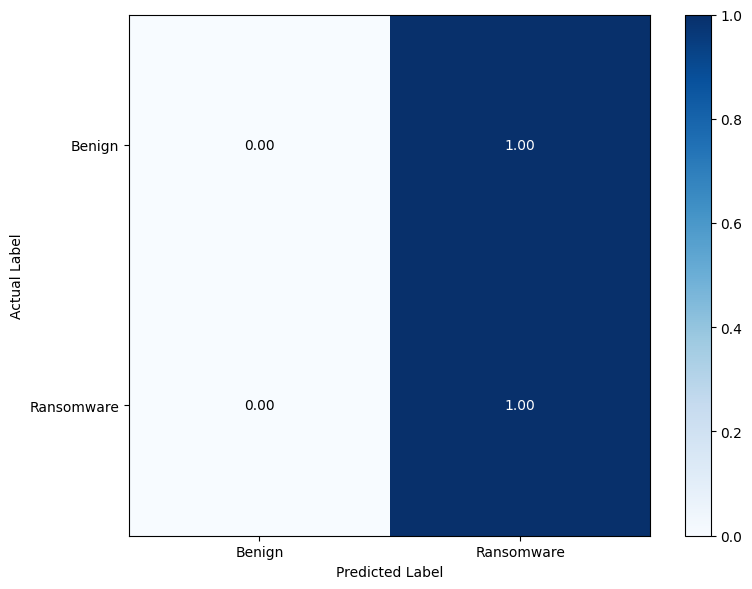

In [ ]:
confusionMatrix_cnn_mtf = confusion_matrix(y_test_int, cnn_mtf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_mtf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_mtf.shape[0]):
    for j in range(confusionMatrix_cnn_mtf.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_mtf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_mtf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

#### ViT

In [ ]:
vit_mtf_pred_int = evaluate(vit_mtf, mtf_test_dataloader, device)

In [ ]:
print('Accuracy:', accuracy_score(y_test_int, vit_mtf_pred_int))
print('Precision:', precision_score(y_test_int, vit_mtf_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_mtf_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_mtf_pred_int, average='macro'))

Accuracy: 0.7924528301886793
Precision: 0.6581632653061225
Recall: 0.5670995670995671
F1-Score: 0.5728937728937729


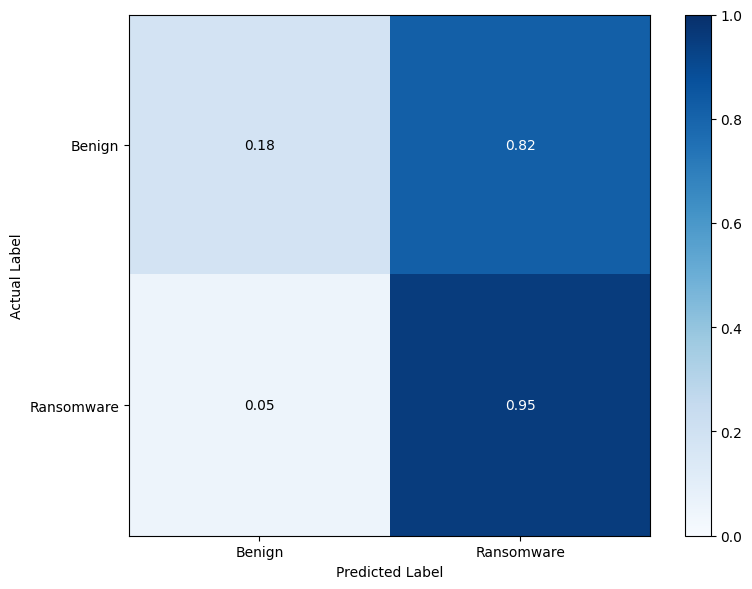

In [ ]:
confusionMatrix_vit_mtf = confusion_matrix(y_test_int, vit_mtf_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_mtf, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_mtf.shape[0]):
    for j in range(confusionMatrix_vit_mtf.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_mtf[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_mtf[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

### MTF Augmentation

In [ ]:
mtf0_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf1_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf2_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf3_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)
mtf4_aug = MarkovTransitionField(image_size=PLOTSIZE, n_bins=2)

In [ ]:
mtf_train_aug_f0 = mtf0_aug.fit_transform(data_train_aug_transposed[:, 0, :])
mtf_train_aug_f1 = mtf1_aug.fit_transform(data_train_aug_transposed[:, 1, :])
mtf_train_aug_f2 = mtf2_aug.fit_transform(data_train_aug_transposed[:, 2, :])
mtf_train_aug_f3 = mtf3_aug.fit_transform(data_train_aug_transposed[:, 3, :])
mtf_train_aug_f4 = mtf4_aug.fit_transform(data_train_aug_transposed[:, 4, :])

In [ ]:
mtf_train_aug = np.empty((data_train_aug_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_train_aug_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_train_aug[i][j][k] = (mtf_train_aug_f0[i][j][k] + mtf_train_aug_f1[i][j][k] + mtf_train_aug_f2[i][j][k] + mtf_train_aug_f3[i][j][k] + mtf_train_aug_f4[i][j][k])/5

In [ ]:
mtf_img_train_aug_tmp = []

for g in mtf_train_aug:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_train_aug_tmp.append(image_array)

In [ ]:
mtf_img_train_aug = np.stack(mtf_img_train_aug_tmp, axis=0)
mtf_img_train_aug = mtf_img_train_aug/255
mtf_img_train_aug.shape

(336, 64, 64, 4)

In [ ]:
mtf_test_f0 = mtf0_aug.transform(data_test_transposed[:, 0, :])
mtf_test_f1 = mtf1_aug.transform(data_test_transposed[:, 1, :])
mtf_test_f2 = mtf2_aug.transform(data_test_transposed[:, 2, :])
mtf_test_f3 = mtf3_aug.transform(data_test_transposed[:, 3, :])
mtf_test_f4 = mtf4_aug.transform(data_test_transposed[:, 4, :])

In [ ]:
mtf_test = np.empty((data_test_transposed.shape[0], PLOTSIZE, PLOTSIZE))
for i in range(data_test_transposed.shape[0]):
    for j in range(PLOTSIZE):
        for k in range(PLOTSIZE):
            mtf_test[i][j][k] = (mtf_test_f0[i][j][k] + mtf_test_f1[i][j][k] + mtf_test_f2[i][j][k] + mtf_test_f3[i][j][k] + mtf_test_f4[i][j][k])/5

In [ ]:
mtf_img_test_tmp = []

for g in mtf_test:
    plt.figure(figsize=(6, 6))
    plt.imshow(g)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()

    buf.seek(0)
    image = Image.open(buf)
    image = image.resize((IMAGESIZE, IMAGESIZE))
    image_array = np.array(image)
    mtf_img_test_tmp.append(image_array)

In [ ]:
mtf_img_test = np.stack(mtf_img_test_tmp, axis=0)
mtf_img_test = mtf_img_test/255
mtf_img_test.shape

(53, 64, 64, 4)

#### CNN with SMOTE

In [ ]:
tf.random.set_seed(SEED)
cnn_mtf_aug = Sequential(name='CNN_MTF_aug')
cnn_mtf_aug.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mtf_img_train_aug.shape[1], mtf_img_train_aug.shape[2], mtf_img_train_aug.shape[3])))
cnn_mtf_aug.add(MaxPooling2D((2, 2)))
cnn_mtf_aug.add(Dropout(0.2))
cnn_mtf_aug.add (Conv2D(16, (3, 3), activation='relu'))
cnn_mtf_aug.add(MaxPooling2D((2, 2)))
cnn_mtf_aug.add(Dropout(0.2))
cnn_mtf_aug.add (Conv2D(8, (3, 3), activation='relu'))
cnn_mtf_aug.add(Flatten())
cnn_mtf_aug.add(Dense(8, activation='relu'))
cnn_mtf_aug.add(Dense(NUMCLASS, activation='softmax'))

cnn_mtf_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\satan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_mtf_aug.summary()

Model: "CNN_MTF_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         9,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,210 (63.32 KB)

 Trainable params: 16,210 (63.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.random.set_seed(SEED)
cnn_mtf_aug_history = cnn_mtf_aug.fit(mtf_img_train_aug, to_categorical(y_train_int_aug), epochs=EPOCH, batch_size=BATCHSIZE, validation_split=VAL)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4684 - loss: 0.6960 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4991 - loss: 0.6936 - val_accuracy: 0.4706 - val_loss: 0.6934
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5436 - loss: 0.6925 - val_accuracy: 0.4706 - val_loss: 0.6940
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5451 - loss: 0.6904 - val_accuracy: 0.5294 - val_loss: 0.6910
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4882 - loss: 0.6944 - val_accuracy: 0.4706 - val_loss: 0.6938
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5478 - loss: 0.6916 - val_accuracy: 0.4706 - val_loss: 0.6934
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5320 - loss: 0.6899 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5421 - loss: 0.6876 - val_accuracy: 0.5441 - val_loss: 0.6869


In [ ]:
cnn_mtf_aug.save(f'{BASE}/Models/cnn_mtf_aug.h5')

#### ViT with SMOTE

In [ ]:
np.random.seed(SEED)
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)
mtf_train_aug_dataloader = DataLoader(NumpyDataset(mtf_img_train_aug, y_train_int_aug, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)
mtf_test_dataloader = DataLoader(NumpyDataset(mtf_img_test, y_test_int, transform), batch_size=BATCHSIZE, shuffle=False, worker_init_fn=np.random.seed(SEED), generator=g)

In [ ]:
torch.manual_seed(SEED)
device = torch.device('cpu')
vit_mtf_aug = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_mtf_aug.head = nn.Linear(vit_mtf_aug.head.in_features, NUMCLASS)
vit_mtf_aug = vit_mtf_aug.to(device)

In [ ]:
for param in vit_mtf_aug.parameters():
    param.requires_grad = False
for param in vit_mtf_aug.head.parameters():
    param.requires_grad = True

In [ ]:
total_params = sum(p.numel() for p in vit_mtf_aug.parameters())
print(f'Total parameters: {total_params:,}')
total_trainable_params = sum(p.numel() for p in vit_mtf_aug.parameters() if p.requires_grad)
print(f'Trainable parameters: {total_trainable_params:,}')

Total parameters: 85,800,194
Trainable parameters: 1,538


In [ ]:
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_mtf_aug.head.parameters(), lr=0.001)

for epoch in range(EPOCH):
    vit_mtf_aug.train()
    running_loss = 0

    for inputs, labels in mtf_train_aug_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vit_mtf_aug(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(mtf_train_aug_dataloader.dataset)
    print(f"Epoch {epoch + 1}/{EPOCH}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 0.7560
Epoch 2/30, Loss: 0.6345
Epoch 3/30, Loss: 0.6363
Epoch 4/30, Loss: 0.6356
Epoch 5/30, Loss: 0.5956
Epoch 6/30, Loss: 0.5617
Epoch 7/30, Loss: 0.5472
Epoch 8/30, Loss: 0.5427
Epoch 9/30, Loss: 0.5394
Epoch 10/30, Loss: 0.5338
Epoch 11/30, Loss: 0.5262
Epoch 12/30, Loss: 0.5184
Epoch 13/30, Loss: 0.5114
Epoch 14/30, Loss: 0.5053
Epoch 15/30, Loss: 0.4998
Epoch 16/30, Loss: 0.4947
Epoch 17/30, Loss: 0.4897
Epoch 18/30, Loss: 0.4849
Epoch 19/30, Loss: 0.4802
Epoch 20/30, Loss: 0.4758
Epoch 21/30, Loss: 0.4716
Epoch 22/30, Loss: 0.4676
Epoch 23/30, Loss: 0.4637
Epoch 24/30, Loss: 0.4600
Epoch 25/30, Loss: 0.4564
Epoch 26/30, Loss: 0.4529
Epoch 27/30, Loss: 0.4495
Epoch 28/30, Loss: 0.4463
Epoch 29/30, Loss: 0.4431
Epoch 30/30, Loss: 0.4401


In [ ]:
torch.save(vit_mtf_aug.state_dict(), f'{BASE}/Models/vit_mtf_aug.pth')

#### Evaluation

##### CNN

In [ ]:
tf.random.set_seed(SEED)
cnn_mtf_aug_pred = cnn_mtf_aug.predict(mtf_img_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:
cnn_mtf_aug_pred_int = np.argmax(cnn_mtf_aug_pred, axis=1)

In [ ]:
print('Accuracy:', accuracy_score(y_test_int, cnn_mtf_aug_pred_int))
print('Precision:', precision_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, cnn_mtf_aug_pred_int, average='macro'))

Accuracy: 0.6981132075471698
Precision: 0.6436011904761905
Recall: 0.7088744588744589
F1-Score: 0.6418918918918919


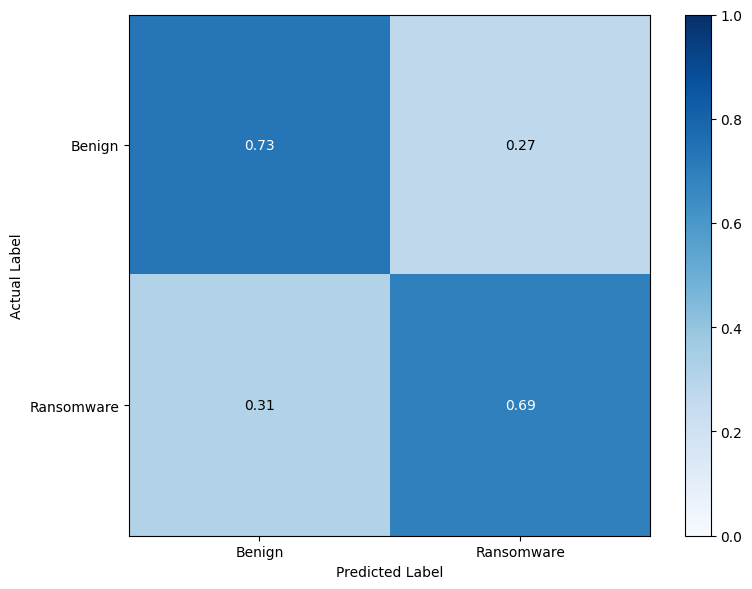

In [ ]:
confusionMatrix_cnn_mtf_aug = confusion_matrix(y_test_int, cnn_mtf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_cnn_mtf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_cnn_mtf_aug.shape[0]):
    for j in range(confusionMatrix_cnn_mtf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_cnn_mtf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_cnn_mtf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

##### ViT

In [ ]:
vit_mtf_aug_pred_int = evaluate(vit_mtf_aug, mtf_test_dataloader, device)

In [ ]:
print('Accuracy:', accuracy_score(y_test_int, vit_mtf_aug_pred_int))
print('Precision:', precision_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))
print('Recall:', recall_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))
print('F1-Score:', f1_score(y_test_int, vit_mtf_aug_pred_int, average='macro'))

Accuracy: 0.6981132075471698
Precision: 0.6070261437908497
Recall: 0.6417748917748918
F1-Score: 0.6117216117216117


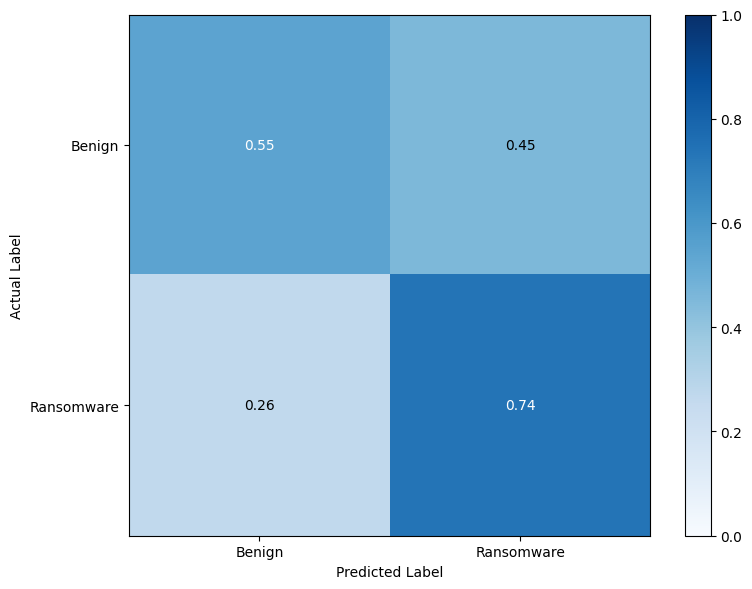

In [ ]:
confusionMatrix_vit_mtf_aug = confusion_matrix(y_test_int, vit_mtf_aug_pred_int, normalize='true')

plt.figure(figsize=(8, 6))
plt.imshow(confusionMatrix_vit_mtf_aug, cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

for i in range(confusionMatrix_vit_mtf_aug.shape[0]):
    for j in range(confusionMatrix_vit_mtf_aug.shape[1]):
        plt.text(j, i, format(confusionMatrix_vit_mtf_aug[i, j], '.2f'), ha='center', va='center', color='white' if confusionMatrix_vit_mtf_aug[i, j] > 0.5 else 'black')

plt.tight_layout()
plt.show()